In [2]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.2' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from temgym_core.source import ParallelBeam
from temgym_core.components import Detector, Lens, Deflector
from temgym_core.gaussian import GaussianRay, evaluate_gaussian_input_image, make_gaussian_image
from temgym_core.utils import fibonacci_spiral, FresnelPropagator
import numpy as np

from __future__ import annotations
import numpy as np
from skimage.restoration import unwrap_phase

jax.config.update("jax_enable_x64", True)

In [3]:
scale = 1  # scale to microns

aperture_window_width = 1e-4
num_aper_pixels = 128
aperture_pixel_size = (aperture_window_width / num_aper_pixels, aperture_window_width / num_aper_pixels)
aperture_radius = aperture_window_width * 0.25

num_beams = int(1)
r1x, r1y = fibonacci_spiral(num_beams, aperture_radius)

wavelength = 1e-8
k = 2 * np.pi / wavelength
wo = 1e-5

aperture_area = np.pi * aperture_radius**2
scale_factor = aperture_area / (wo ** 2 * num_beams * np.pi)

/home/dl277493/Microscope-Calibration/TemGymCore/src/temgym_core/utils.py:310: RuntimeWarning: invalid value encountered in sqrt
  radius * np.sqrt((ii + 0.5) / (nb_samples - 0.5 * (np_boundary + 1)))


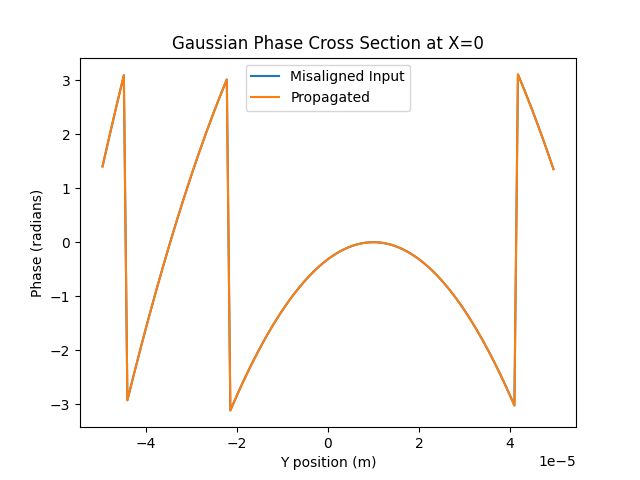

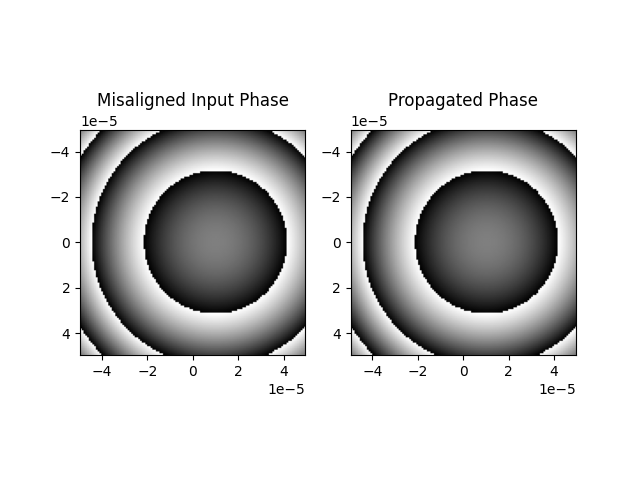

In [40]:
ray =  GaussianRay(x=1e-5, 
                   y=0.0, 
                   dx=0.0, 
                   dy=0.0, 
                   z=0.0, 
                   pathlength=0.0, 
                   _one=1.0, 
                   amplitude=1.0, 
                   waist_xy=jnp.array([1e-5, 1e-5]), 
                   radii_of_curv=jnp.array([1e-1, 1e-1]), 
                   wavelength=1e-8,
                   theta=0.0)

defocus = 1e-13
F1 = 0.01
parallel_beam = ParallelBeam(z=0.0, radius=aperture_radius)
lens = Lens(z=0.0, focal_length=F1)
detector = Detector(z=defocus, pixel_size=(aperture_pixel_size[0], aperture_pixel_size[1]), shape=(num_aper_pixels, num_aper_pixels))
model = [parallel_beam,  detector]
detector_xy = detector.coords_1d
extent_x = detector.coords_1d[0][0], detector.coords_1d[0][-1]
extent_y = detector.coords_1d[1][0], detector.coords_1d[1][-1]

detector_coords = detector.coords
X, Y = detector_coords[:, 0], detector_coords[:, 1]
X = X.reshape((num_aper_pixels, num_aper_pixels))
Y = Y.reshape((num_aper_pixels, num_aper_pixels))   

input_rays = ray.derive(z=jnp.zeros(num_beams))
Q1_invs = input_rays.Q_inv
misaligned_input_gauss_image = evaluate_gaussian_input_image(input_rays, detector, batch_size=100)
propagated_gauss_image = make_gaussian_image(input_rays, model, batch_size=100)
# Cross-section through the center column (X=0)
center_x_idx = num_aper_pixels // 2
x_line = X[center_x_idx, :]
amp_section_mis = jnp.angle(misaligned_input_gauss_image)[center_x_idx, :]

# Cross-section through the center column (X=0)
x_line = X[center_x_idx, :]
amp_section_prop = jnp.angle(propagated_gauss_image)[center_x_idx, :]

plt.figure()
plt.plot(x_line, amp_section_mis, label='Misaligned Input')
plt.xlabel('Y position (m)')
plt.ylabel('Phase (radians)')
plt.title('Gaussian Phase Cross Section at X=0')
plt.plot(x_line, amp_section_prop, label='Propagated')
plt.legend()

fig, ax = plt.subplots(1, 2)
ax[0].set_title('Misaligned Input Phase')
ax[0].imshow(jnp.angle(misaligned_input_gauss_image), cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
ax[1].set_title('Propagated Phase')
ax[1].imshow(jnp.angle(propagated_gauss_image), cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))